In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib import rc
import seaborn as sns
plt.rcParams['ps.useafm'] = True
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

import pandas as pd
import time
import shutil
import argparse
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('/DATA/lucaa/software/CLoNe')

from clone import CLoNe
from plot import plot_clusters
from structural_utils import load_md_args, show_cluster_info

import mdtraj
import pyemma

print(__doc__)
start = time.time()


def calculate_pca(topo, traj, main_folder, syst, at_sel, n_pca ):
    # Load trajectory
    topology = mdtraj.load(topo).topology
    struct_ens = mdtraj.load(traj, top=topo)

    # Create result folder based on dataset nam\e
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    out_idx =  1
    output_folder = main_folder+"/%s_%i/"
    while os.path.exists(output_folder%(syst, out_idx)):
        out_idx += 1
    output_folder = output_folder%(syst, out_idx)
    os.makedirs(output_folder)
    

    selection = struct_ens.topology.select(at_sel)
    coords = struct_ens.xyz[:, selection]
    coords = coords.reshape(coords.shape[0], coords.shape[1] * coords.shape[2])
    headers = ["C%i"%x for x in range(len(coords[0]))]  # general headers

    # Principal component analysis
    original_coords = coords.copy()
    pca_obj = PCA(n_components=n_pca)
    reddim_coords = pca_obj.fit_transform(coords)
    eigenvalues = pca_obj.explained_variance_ratio_
    ratio = np.sum(eigenvalues[:n_pca])
    pca_headers = ["PC%i (%.2f)"%(x + 1, eigenvalues[x]) for x in range(n_pca)]
    
    print("> PCA: %i => %i dimension(s) with eigenval.: %s"%(len(headers), n_pca, str(eigenvalues)))
    print("sum of Variance: %s"%(np.sum(eigenvalues)))
    with open("%sPCA_coords.txt"%output_folder, "w") as f:
        for x in range(n_pca):
            f.write("PC%i(%.2f) "%(x + 1, eigenvalues[x]))
        f.write("\n")
        for el in reddim_coords:
            for n in el:
                f.write("%f "%n)
            f.write("\n")  
    return pca_obj, reddim_coords, original_coords


def calc_magn_vector(pc):
    final_length = int(len(pc)/3)
    pc_magn = np.empty(final_length)
    
    for i in range(final_length):
        pc_magn[i] = np.sqrt(pc[i*3]**2+pc[i*3+1]**2+pc[i*3+2]**2)
    
    return pc_magn


def save_pc_bfact(init_padding, length_pc, final_padding, structure, pc_component, outpdb):

    pc_elongated = np.concatenate((np.zeros(init_padding),calc_magn_vector(pc_component),np.zeros(final_padding)))
    system_length_res = len([residue for residue in structure.topology.residues])
    system_length_atoms = len([ atom for atom in structure.topology.atoms])

    syst_bfact=np.zeros(system_length_atoms)
    index=0
    for resid in range(system_length_res):
        res_len = len(structure.topology.select('resid '+str(resid)))
        res_bfact= res_len
        syst_bfact[index:index+res_len] = pc_elongated[resid]
        index += res_len

    structure[0].save_pdb(outpdb, bfactors=syst_bfact*100)
    
# Check convercence PC
def calculate_pca_convergence(topo, traj, main_folder, syst, at_sel, n_pca, nframes, nsim ):
    # Load trajectory
    topology = mdtraj.load(topo).topology
    struct_ens = mdtraj.load(traj, top=topo)

    # Create result folder based on dataset nam\e
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    out_idx =  1
    output_folder = main_folder+"/%s_%i/"
    while os.path.exists(output_folder%(syst, out_idx)):
        out_idx += 1
    output_folder = output_folder%(syst, out_idx)
    os.makedirs(output_folder)
    
    selection = struct_ens.topology.select(at_sel)
    coords = struct_ens.xyz[:, selection]
    coords = coords.reshape(coords.shape[0], coords.shape[1] * coords.shape[2])
    headers = ["C%i"%x for x in range(len(coords[0]))]  # general headers
    
    frameslist = np.multiply(np.arange(1,nsim+1),nframes)
    original_coords = coords.copy()
    pcas_list = []
    reddim_coords_list = []
    print(np.shape(coords))
    # Principal component analysis
    for section in frameslist:
        pca_obj = PCA(n_components=n_pca)
        
        reddim_coords = pca_obj.fit_transform(coords[0:section])
        pcas_list.append(pca_obj)
        #eigenvalues = pca_obj.explained_variance_ratio_
        #ratio = np.sum(eigenvalues[:n_pca])
        #pca_headers = ["PC%i (%.2f)"%(x + 1, eigenvalues[x]) for x in range(n_pca)]
    
        #print("> PCA: %i => %i dimension(s) with eigenval.: %s"%(len(headers), n_pca, str(eigenvalues)))
        #print("sum of Variance: %s"%(np.sum(eigenvalues)))
  
    return pcas_list

Automatically created module for IPython interactive environment


In [2]:
# PARAMETERS SETUP

# Clustering parameters 
pdc=8   # neighbour search during clusterint
n_resize=4 
filt=0.1 
verbose=False
n_pca=10 # number of PC to include in calculations 
n_bins= 100  # number of bins for PC hist
# Simulations and topology 

trj_tot='smp_tot_chain1.xtc'   # concatenated total traj
trj_tot_wres='smp_3states_chain1.xtc'

topo_apo='apo_chain1.gro'  # pdb or gro of apo
#topo_holo='22dog.gro' # pdb or gro of holo

# Selection for PCA calculation (see mdtraj syntax)
at_sel="name CA and residue 4 to 179"  # try to exclude end loops or regions that move but are not interesting (hides the true PC)
n_res=175   # number of residues (still manual insertion, i know...)
resmin=4
resmax=179
feat="None"

output_folder = "results"

apo_name="apo"
holo_name="holo"
tot_name="tot"

In [9]:
try:
    os.mkdir(output_folder)
except FileExistsError:
    pass
try:
    os.mkdir(output_folder+'/IMAGES/')
except FileExistsError:
    pass
# Calculate PCA
#pca_apo, red_dim_coords_apo, orig_coords_apo = calculate_pca(topo_apo, trj_apo, output_folder, apo_name, at_sel, n_pca)
#pca_holo, red_dim_coords_holo, orig_coords_holo = calculate_pca(topo_holo, trj_holo, output_folder, holo_name, at_sel, n_pca)
pca_tot, red_dim_coords_tot, orig_coords_tot = calculate_pca(topo_apo, trj_tot, output_folder, tot_name, at_sel, n_pca)

> PCA: 528 => 10 dimension(s) with eigenval.: [0.3632338  0.16154808 0.06673901 0.05785625 0.04241489 0.0281762
 0.02229902 0.01836157 0.0162691  0.013907  ]
sum of Variance: 0.7908049


In [10]:
pca_tot_wres, red_dim_coords_tot_wres, orig_coords_tot_wres = calculate_pca(topo_apo, trj_tot_wres, output_folder, tot_name, at_sel, n_pca)

> PCA: 528 => 10 dimension(s) with eigenval.: [0.32045849 0.19550644 0.06888537 0.05604967 0.03710073 0.03009798
 0.02701014 0.01827619 0.01610845 0.01582107]
sum of Variance: 0.7853145293341569


In [11]:
index_apo_end= 29400 #np.shape(red_dim_coords_apo)[0]
index_tot_end=np.shape(red_dim_coords_tot)[0]
index_tot_wres_end=np.shape(red_dim_coords_tot_wres)[0]


Figures PC and histogrames checking that all pc apo, holo and tot are the same 

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,3), sharex=True, sharey=True)
n_res_pc = len(calc_magn_vector(pca_apo.components_[0]))
# TODO: check dimensions or automatize axis generation 
tick_spacing = 20
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[0].tick_params(axis='x', rotation=90)

ax[0].set_xlim(resmin,resmax)
ax[0].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_tot.components_[0,0:528]), linewidth=0.8, color='green')
ax[1].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_tot_wres.components_[0,0:528]), linewidth=0.8, color='dodgerblue')

sns.despine()

ax[0].legend(['Apo+Holo'], frameon=False)
ax[1].legend(['Apo+Holo+Resample'], frameon=False)

ax[0].set_xlabel("# Residue", fontsize=20, labelpad=5)
ax[1].set_xlabel("# Residue", fontsize=20, labelpad=5)
ax[0].set_ylabel("PC component (a.u.)", fontsize=20, labelpad=5)
fig.tight_layout()

fig.savefig(output_folder+'/IMAGES/comparison_pc_apo_holo_tot.pdf')

plt.show()

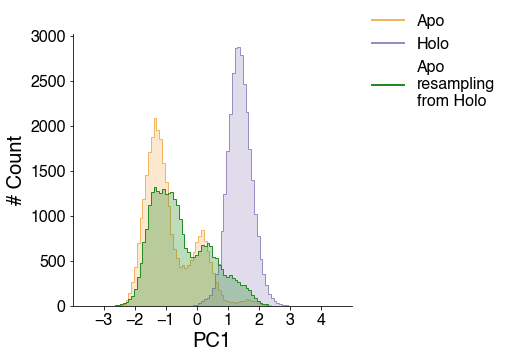

In [15]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

min_pc = -4
max_pc = 5

sns.despine()
ax.set_xlim([min_pc,max_pc])
ax.set_xticks([-3,-2,-1,0,1,2,3,4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("# Count", fontsize=20)
#F3B562 #998EC3
ax.hist(red_dim_coords_tot_wres[0:index_apo_end,0], color='#F3B562', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot_wres[0:index_apo_end,0], color='#F3B562', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_tot_wres[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot_wres[index_apo_end:index_tot_end,0], color='#998EC3', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

ax.hist(red_dim_coords_tot_wres[index_tot_end:index_tot_wres_end,0], color='forestgreen', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot_wres[index_tot_end:index_tot_wres_end,0], color='forestgreen', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

legend_elements = [Line2D([0], [0], color='#F3B562', lw=2, label='Apo'),
                   Line2D([0], [0], color='#998EC3', lw=2, label='Holo'), 
                   Line2D([0], [0], color='forestgreen', lw=2, label='Apo\nresampling\nfrom Holo')]
ax.legend(frameon=False, fontsize=16, handles = legend_elements, loc=(1.05,0.7))
#ax.set_title("Apo vs. Holo population", fontsize=16)

#fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/histograms_pc_withapofromholo.pdf')
plt.show()

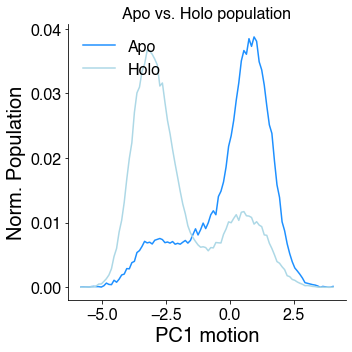

# Clustering


In [ ]:
clone_apo = CLoNe(pdc=pdc)
clone_holo = CLoNe(pdc=pdc)


clone_apo.fit(red_dim_coords_tot[0:index_apo_end,0].reshape(-1, 1)) 
clone_holo.fit(red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1)) 

In [ ]:
pca_headers = ["PC%i"%(x + 1) for x in range(n_pca)]
plot_clusters(clone_apo, red_dim_coords_tot[0:index_apo_end,0].reshape(-1, 1), output_folder,pca_headers[:2] ) 
plot_clusters(clone_holo, red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1), output_folder,pca_headers[:2] )

Save Clusters with water DANGEROUS FOR MEMORY

In [20]:
# Load trajectories
struct_apo = mdtraj.load("new_500ns/apo_tot.xtc", top="new_500ns/apo/md_cptp_apo_seed1_center_pbcmol_fit_rot_trans_prot.gro")
struct_holo = mdtraj.load("new_500ns/holo_tot.xtc", top="new_500ns/holo_dlpa/md_cptp_holo_seed1_center_pbcmol_fit_rot_trans_prot.gro")


In [21]:
save_clusters(clone_apo,struct_apo, output_folder+'/'+apo_name+'_1')
save_clusters(clone_holo,struct_holo, output_folder+'/'+holo_name+'_1')
# TODO: here the folder is selected manually. This should be automated but I don't have time to rewrite everything now